# 442b Homework

In [347]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [348]:
df = pd.read_csv('hw3_data.csv')

In [349]:
df.tail()

,Date,Health_PE,HealthSector_Returns,Industrial_PE,IndustrialSector_Returns
8263,2024-01-26,19.8396,0.006819,21.2431,0.003013
8264,2024-01-29,19.9753,0.002470,21.3780,0.011887
8265,2024-01-30,20.0247,-0.001112,21.3879,-0.012228
8266,2024-01-31,19.9998,0.012589,21.1433,0.000915
8267,2024-02-01,20.2532,0.001508,21.5030,0.007644


In [350]:
df['Date'] = pd.to_datetime(df['Date'])

### a) Perform a fisher transform on each of the P/E rartios where the transformation window size for Health is 756 observations and 1764 observations for the Industrial Sector.

In [351]:
#Lets do a fisher transformation on Health_PE and Industrial_PE from df
# Function to calculate strategy returns given parameters
def fisher_transformation(data, s,fundamental):
    #s is the size of the windows
    data_copy = data.copy()
    data_copy['roll_min'] = data_copy[[fundamental]].rolling(int(s)).min()
    data_copy['roll_max'] = data_copy[[fundamental]].rolling(int(s)).max()
    data_copy['fisher'] = (data_copy[fundamental] - data_copy['roll_min']) / (data_copy['roll_max'] - data_copy['roll_min'])
    #I know create a column with the fundamental name and the word fisher
    data_2 = pd.DataFrame(data_copy['fisher'])
    data_2.columns = [fundamental + '_fisher']  
    data_2.set_index(data_copy.index, inplace=True)
    return data_2
   
#We multiply by 100 because the heatmap will be more readable, as the values will be closer to 0

In [352]:
Health_FPE = fisher_transformation(df, 756, 'Health_PE')
Industrial_FPE = fisher_transformation(df, 1764, 'Industrial_PE')   

In [353]:
#Lets merge df, Health_FPE and Industrial_FPE
df2 = pd.concat([df, Health_FPE, Industrial_FPE], axis=1)
df2.tail()

,Date,Health_PE,HealthSector_Returns,Industrial_PE,IndustrialSector_Returns,Health_PE_fisher,Industrial_PE_fisher
8263,2024-01-26,19.8396,0.006819,21.2431,0.003013,0.951873,0.230151
8264,2024-01-29,19.9753,0.002470,21.3780,0.011887,0.975954,0.233347
8265,2024-01-30,20.0247,-0.001112,21.3879,-0.012228,0.984721,0.233582
8266,2024-01-31,19.9998,0.012589,21.1433,0.000915,0.980302,0.227786
8267,2024-02-01,20.2532,0.001508,21.5030,0.007644,1.000000,0.236309


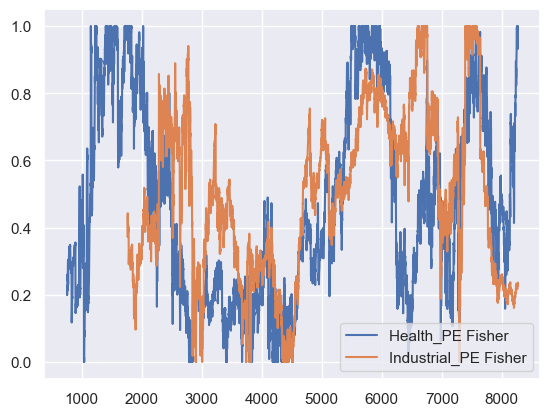

In [354]:
#Lets plot IndustrialSector_PE and HealthSector_PE
fig, ax = plt.subplots()
ax.plot(df2['Health_PE_fisher'], label='Health_PE Fisher')
ax.plot(df2['Industrial_PE_fisher'], label='Industrial_PE Fisher')
ax.legend()
plt.show()

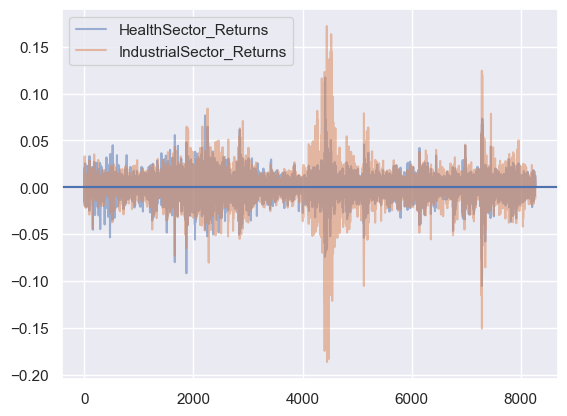

In [355]:
fig, ax = plt.subplots()
ax.plot(df2['HealthSector_Returns'], label='HealthSector_Returns',alpha=0.5)
ax.plot(df2['IndustrialSector_Returns'], label='IndustrialSector_Returns',alpha=0.5)
#lets draw a line with the mean of the returns
ax.axhline(y=df2['HealthSector_Returns'].mean(), color='r', linestyle='-')
ax.axhline(y=df2['IndustrialSector_Returns'].mean(), color='b', linestyle='-')

ax.legend()
plt.show()

### b) Write python code that will implement a trading strategy that will enter a short position when the fisher transformed PE of a sector crosses below an upper threshold and go long when we cross above a lower threshold. Once you enter a position, you will only exit when you receive a signal in the opposite direction. (Note: Neither the lecture or the exercise did exactly this, since we entered positions when we crossed the thresholds the first time. You must make changes).

In [356]:
def strategy(data_copy, u1, l1, fundamental):
    data_copy = data_copy.copy()
    data_copy['pos1'] = np.NaN
    data_copy.loc[data_copy.loc[(data_copy[fundamental].shift() > u1) & (data_copy[fundamental] < u1)].index, 'pos1'] = -1 
    #When the fisher crosses the upper threshold, we short the asset
    data_copy.loc[data_copy.loc[(data_copy[fundamental].shift() < l1) & (data_copy[fundamental] > l1)].index, 'pos1'] = 1
    #When the fisher crosses the lower threshold, we long the asset
    data_copy['pos1'] = data_copy['pos1'].ffill()
    #ffill is used to fill the NaN values with the last non-NaN value
    data_copy['signal'] = data_copy['pos1']
    
    data_2 = pd.DataFrame(data_copy['signal'])
    data_2.columns = [fundamental + '_signal']
    data_2.set_index(data_copy.index, inplace=True)

    return data_2

Example with u1=0.35 and l1=30

In [357]:
strategy_Health = strategy(df2, 0.35, 0.30, 'Health_PE_fisher')

In [358]:
strategy_Health.tail()

,Health_PE_fisher_signal
8263,-1.0
8264,-1.0
8265,-1.0
8266,-1.0
8267,-1.0


### c) Test at least 400 different combinations of valid (Upper threshold greater than or equal to lower threshold) hyperparameters for your boundaries for each fisher transformed series of PEs. Use the geometric mean of returns as your metric for the success of each outcome. 

In [359]:
def geometric_return(data_copy, fundamental,sector_returns,strategy_results_1):
    # Calculate strategy returns
    data_copy = data_copy.copy()
    data_copy["strat returns"] = (strategy_results_1[fundamental + '_signal'].shift() * data_copy[sector_returns])
    #the returns are the change of Close
    data_copy["strat returns"] = data_copy["strat returns"].fillna(0)
    #Getting the geometric mean of the returns
    geom_return = (((data_copy["strat returns"]+1).prod())**(1/len(data_copy["strat returns"])))-1
    return geom_return

In [360]:
#Number would be the area of a triangle with same base and height
n_w = 50
n_w*(n_w-1)/2


1225.0

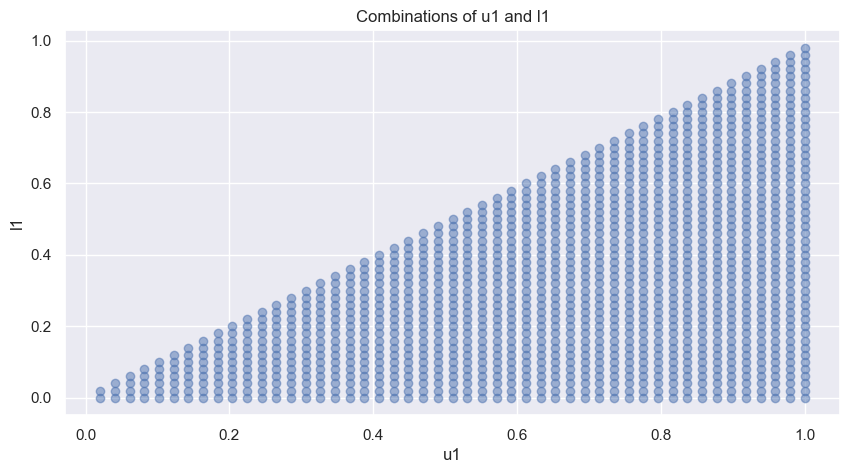

In [361]:
#Combinatios of upper and lower thresholds
# Step 1: Generate an array of points between 0 and 1
u1 = np.linspace(0,1,n_w)
l1 = np.arange(0,1,1/n_w)
#Lets create all the combinatios of u1 and l1 where u1 > l1
u1, l1 = np.meshgrid(u1, l1) #meshgrid is used to create a matrix of combinations
u1 = u1.flatten() #flatten is used to convert the matrix into a vector
l1 = l1.flatten()
#We create a dataframe with the combinations
df_combinations = pd.DataFrame({'u1': u1, 'l1': l1})
df_combinations = df_combinations[df_combinations['u1'] > df_combinations['l1']]

#plot the combinations
plt.figure(figsize=(10,5))
plt.scatter(df_combinations['u1'], df_combinations['l1'], alpha=0.5)
plt.xlabel('u1')
plt.ylabel('l1')
plt.title('Combinations of u1 and l1')
plt.show()


In [362]:
len(df_combinations)

1274

In [363]:

#We test the 400 combinatios of u1 and l1. We are going to store the results in a list of dictionaries
fundamentals = ['Health_PE_fisher', 'Industrial_PE_fisher']
sectors_returns_names = ['HealthSector_Returns', 'IndustrialSector_Returns']
industries = ['Health', 'Industrial']

results = {'u1': [], 'l1': [], 'Geom_Return': [], 'Industry': []}

#trasnform df_combinations
df_combinations = df_combinations.values
#We are going to iterate over the combinations of u1 and l1
for u1, l1 in df_combinations:
    for i in range(2):
        results['u1'].append(u1)
        results['l1'].append(l1)
        strategy_results = strategy(df2, u1, l1, fundamentals[i])
        #Lets merge strategy and df2
        geom_return = geometric_return(df2, fundamentals[i], sectors_returns_names[i], strategy_results)
        results['Geom_Return'].append(geom_return)
        results['Industry'].append(industries[i])
# Convert results to a DataFrame for easier handling
results_df = pd.DataFrame(results)
#we are going to convert the list of dictionaries into a DataFrame
sorted_results = results_df.sort_values(by='Geom_Return', ascending=False)
#we are going to sort the DataFrame by the Sharpe ratio in descending order
sorted_results = sorted_results.dropna()
    
    

In [364]:
#Lets group by Industry and get the top 5 best combination of u1 and l1
best_combinations = sorted_results.groupby('Industry').head(10)
#Lets arrange the DataFrame by Industry and Geom_Return
best_combinations = best_combinations.sort_values(by=['Industry', 'Geom_Return'], ascending=[True, False])
best_combinations

,u1,l1,Geom_Return,Industry
388,0.102041,0.08,0.000374,Health
478,0.102041,0.10,0.000324,Health
292,0.061224,0.06,0.000310,Health
386,0.081633,0.08,0.000306,Health
986,1.000000,0.20,0.000306,Health
1064,1.000000,0.22,0.000306,Health
1140,1.000000,0.24,0.000305,Health
1214,1.000000,0.26,0.000305,Health
100,0.040816,0.02,0.000304,Health
1356,1.000000,0.30,0.000302,Health


## Part 2 - Hyperparameter analysis


### a) Create two properly labelled heat maps (with a clear distinction between the values of the heat map, scaling may be required) for your tested hyper parameter values in the industrial and health sectors.

In [365]:
#Heatmap 
import seaborn as sns
#This function is going to plot the heatmap
def heatmap(x, y, metric, values, title = 'Heatmap'):
    #S is the window size
    # specify the columns I will be pulling from the results
    p2p = values[[x, y, metric]]
    #subsetting the DataFrame
    # If p > 2, we need to group 
    heat = np.round(p2p.groupby([x,y]).mean(),5)
    #grouping the DataFrame by the x and y columns and calculating the mean of the metric
    heat = heat.unstack()[metric] #transform the DataFrame into a matrix
    #This will create a matrix, with the x values as the index and the y values as the columns.
    #the values within the matrix are the metric

    # round labels
    heat.index = np.round(heat.index,2) #we are going to round the index
    #We are rounding the x that has become the index after the unstack
    heat.columns = np.round(heat.columns,2) #we are going to round the columns

    # make plot
    f, ax = plt.subplots(figsize=(11.5, 5))
    ax = sns.heatmap(heat, fmt='.1g') #plot this matrix as a heatmap
    ax.set_title(title,size = 18)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlabel(y, size = 18)
    ax.set_ylabel(x, size = 18)
    ax.collections[0].colorbar.set_label(metric, size = 18)
    sns.set(font_scale=1)
    #Lets delimit the heatmap colors to be between the minimum and maximum values of the metric
    plt.show()

Health Sector

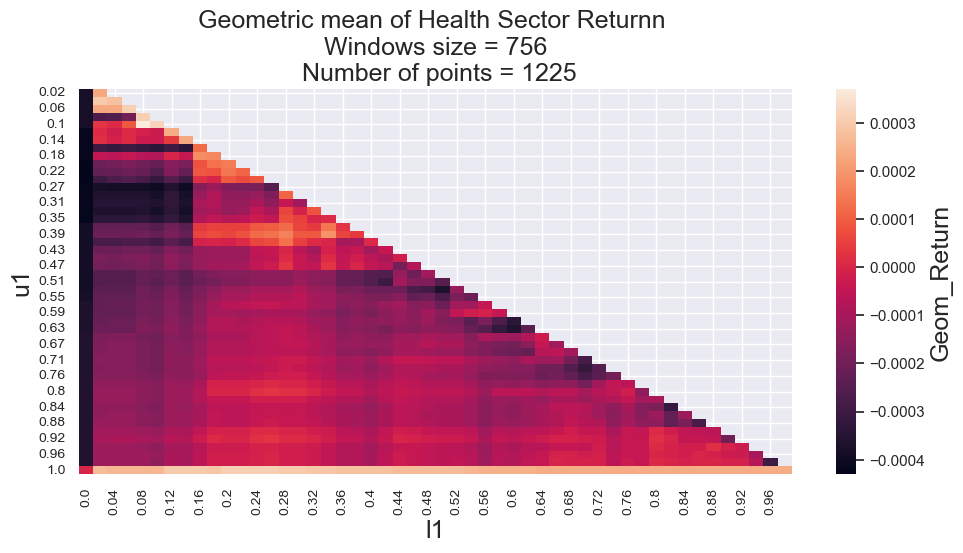

In [366]:
temp = sorted_results[sorted_results['Industry'] == 'Health']
heatmap("u1", "l1","Geom_Return", temp, title = 'Geometric mean of Health Sector Returnn \n Windows size = 756 \n Number of points = 1225')

Industrial Sector

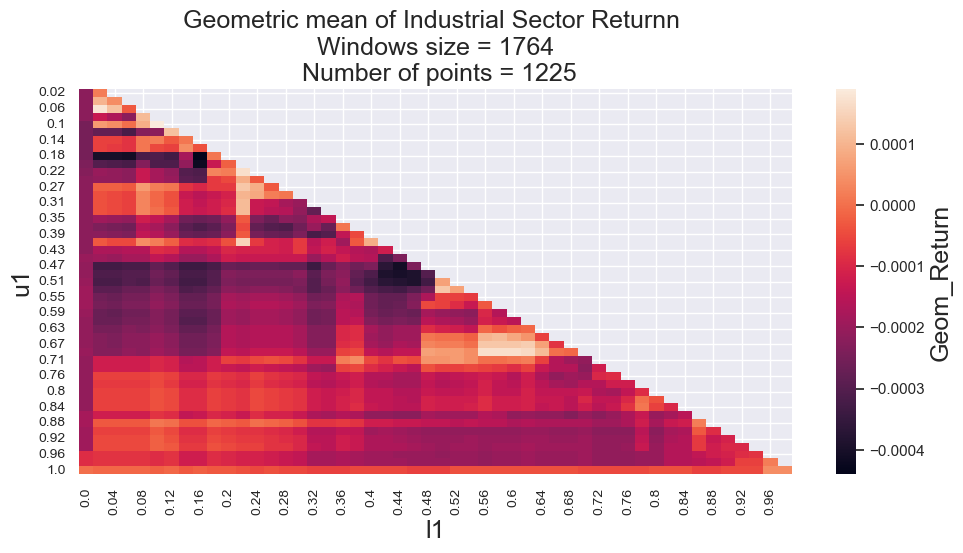

In [367]:
temp = sorted_results[sorted_results['Industry'] == 'Industrial']
heatmap("u1", "l1","Geom_Return", temp, title = 'Geometric mean of Industrial Sector Returnn \n Windows size = 1764 \n Number of points = 1225')

### c) What do the heatmaps tell you about the hyperparameters that are best for each sector? Is there any similarity between the two?

Heathmap represents the geometric means of the returns generated from the combinatios of two candidate hyperparameters values. The areas with a consistent color for positive returns would tell us where the hyperparameters consistently and robustly give us the biggest profit. <br>


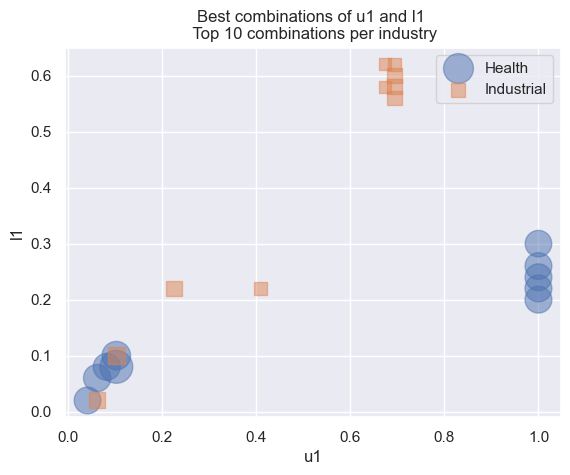

In [368]:
import matplotlib.pyplot as plt

# Plot the best combinations, with color representing the geometric return and shape representing the industry
fig, ax = plt.subplots()
for industry, data in best_combinations.groupby('Industry'):
    if industry == 'Health':
        marker_shape = 'o'  # Círculos para la industria de la salud
    else:
        marker_shape = 's'  # Cuadrados para otras industrias
    ax.scatter(data['u1'], data['l1'], s=(data['Geom_Return']**(2))*4000000000, label=industry, alpha=0.5, marker=marker_shape)
ax.set_xlabel('u1')
ax.set_ylabel('l1')
ax.set_title('Best combinations of u1 and l1 \n Top 10 combinations per industry')
ax.legend()
plt.show()


In the **Health Industry**, the heatmap provides insightful data, especially when examining the sector's return behavior. It's observed that this sector generally exhibits upward-trending returns. Consequently, the optimal thresholds identified for our model are those that predominantly favor a long strategy, specifically settings where short positions are never recommended (u1 = 1) or scenarios where the upper threshold is marginally above the lower threshold with low values, almost entirely sidelining the short strategy (u1 = 0.1 & l1 = 0.08). These parameters stand out for their robustness and consistency among the leading combinations for returns, aligning well with a sector characterized by persistently positive long-term returns and a quick rebound capacity during downturns. The absence of exceptionally high peaks implies that the model, based on historical data, does not advocate for short positions, although this doesn't preclude potential future downtrends in the sector.

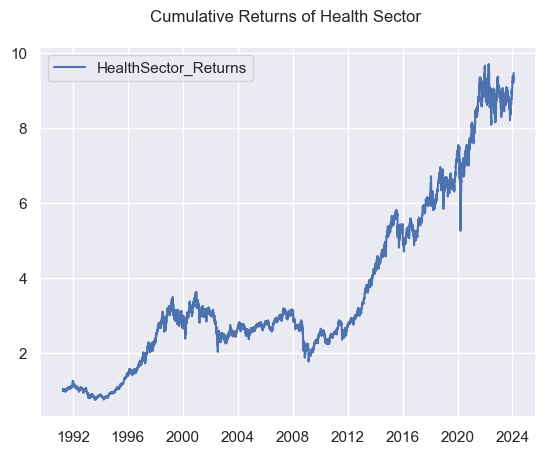

In [369]:
#Lets plot the cumulative returns of the health sector, using Dates as x label
fig, ax = plt.subplots()
ax.plot(df2['Date'], (df2['HealthSector_Returns']+1).cumprod(), label='HealthSector_Returns')
ax.legend()
ax.set_title('Cumulative Returns of Health Sector \n')
plt.show()

In contrast, the Industry sector exhibits pronounced peaks, followed by significant declines in stock prices. These fluctuations provide the model with critical data to establish an upper and lower threshold. The presence of both lower and upper extreme values in the cumulative returns informs the heatmap analysis, indicating that optimal thresholds likely reside in moderate ranges (u1 = 0.7 & l1 = 0.6). Such thresholds are strategically set to capitalize on the sector's volatility, allowing the model to effectively respond to significant price movements and enhance predictive accuracy.

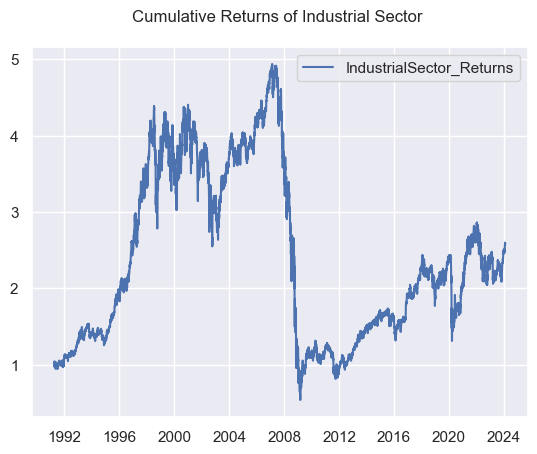

In [370]:
#Lets plot the cumulative returns of the Industry sector, using Dates as x label
fig, ax = plt.subplots()
ax.plot(df2['Date'], (df2['IndustrialSector_Returns']+1).cumprod(), label='IndustrialSector_Returns')
ax.legend()
ax.set_title('Cumulative Returns of Industrial Sector \n')
plt.show()

The commonality observed in the two heatmaps is the presence of specific data points that likely represent outliers, manifesting as non-robust optimal combinations. These combinations appear optimal at a singular point but do not maintain optimality across the surrounding data points. Such anomalies necessitate cautious analysis to ensure the selection of hyperparameter combinations that demonstrate robustness, thereby optimizing the model's overall performance. It's crucial to differentiate between genuinely optimal parameter sets and those that appear advantageous due to outlier effects, focusing on consistency in the heatmap patterns to guide the optimization of the model.

### d) Based on what you learned from the heatmaps, pick a pair of hyperparameters for the health and industrial sector strategies and visualize the equity curve the produce for each.

In [371]:
#We select the following combination of u1 and l1
u1_h , l1_h = (0.1, 0.08)
u1_i , l1_i = (0.7, 0.6)

In [372]:
strategy_h = strategy(df2, u1_h, l1_h, 'Health_PE_fisher')
strategy_i = strategy(df2, u1_i, l1_i, 'Industrial_PE_fisher')

In [373]:
returns_h = geometric_return(df2, 'Health_PE_fisher', 'HealthSector_Returns', strategy_h)
returns_i = geometric_return(df2, 'Industrial_PE_fisher', 'IndustrialSector_Returns', strategy_i)

For health sector

In [374]:
df4 = df2.copy()
df4["strat returns"] = (strategy_h['Health_PE_fisher_signal'].shift() * df4['HealthSector_Returns'])
#the returns are the change of Close
df4["strat returns"] = df4["strat returns"].fillna(0)
#Getting the geometric mean of the returns
df4['Cumulative Returns'] = (df4["strat returns"]+1).cumprod()

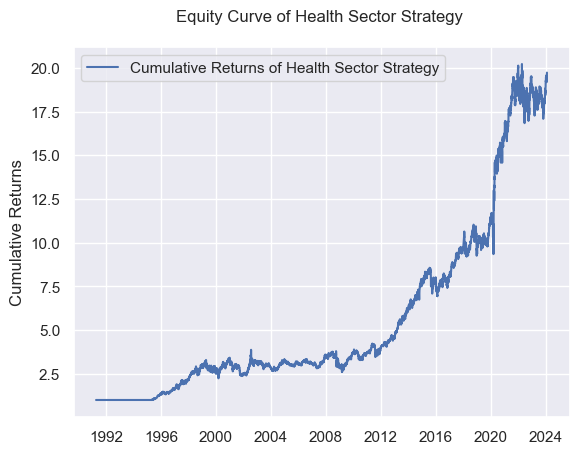

In [375]:
#Lets plot the equity curve. Lets use Date as the x axis
fig, ax = plt.subplots()
ax.plot(df4['Date'], df4['Cumulative Returns'], label='Cumulative Returns of Health Sector Strategy')
ax.legend()
plt.title('Equity Curve of Health Sector Strategy \n')
plt.ylabel('Cumulative Returns')
plt.show()


For industry

In [376]:
df5 = df2.copy()
df5["strat returns"] = (strategy_i['Industrial_PE_fisher_signal'].shift() * df5['IndustrialSector_Returns'])
#the returns are the change of Close
df5["strat returns"] = df5["strat returns"].fillna(0)
#Getting the geometric mean of the returns
df5['Cumulative Returns'] = (df5["strat returns"]+1).cumprod()

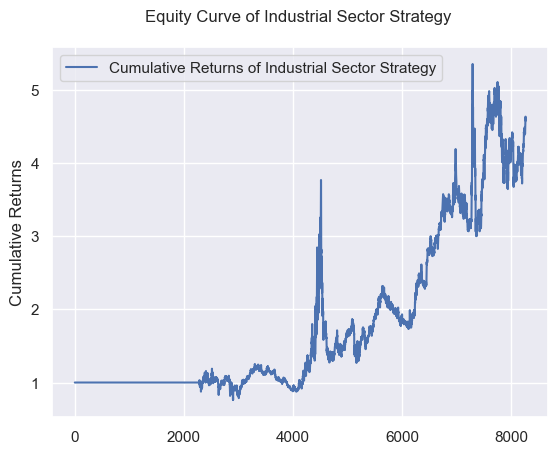

In [377]:
#lets plot equity curve
fig, ax = plt.subplots()
ax.plot(df5['Cumulative Returns'], label='Cumulative Returns of Industrial Sector Strategy')
ax.legend()
plt.title('Equity Curve of Industrial Sector Strategy \n')
plt.ylabel('Cumulative Returns')
plt.show()


## Part 3 - Portfolio creation

### a) Use the outcomes you generated in 2c to create an equally weighted portfolio.


In [378]:
#Combine df4 and df5 strat_returns
df6 = pd.concat([df4['strat returns'], df5['strat returns']], axis=1)
df6.columns = ['HealthSector_Strat_Returns', 'IndustrialSector_Strat_Returns']
df6 = pd.merge(df6, df2['Date'], left_index=True, right_index=True)

In [379]:
df6.set_index('Date', inplace=True)

In [380]:
#Lets select the Strat returns and calculate the portfolio returns
portfolio_returns = np.log(df6+1).sum(axis=1)/2
portfolio_returns.tail()

Date
2024-01-26    0.004902
2024-01-29    0.007142
2024-01-30   -0.006708
2024-01-31    0.006712
2024-02-01    0.004561
dtype: float64

### b)  Show the equity curve of the portfolio from the previous part.

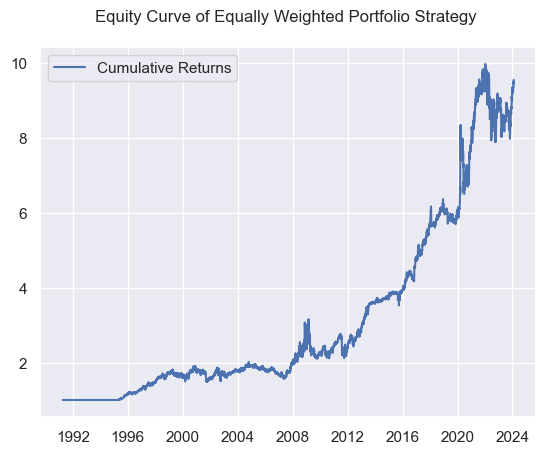

In [381]:
#Lets plot the equity curve of the portfolio_returns
df6['portfolio_returns'] = portfolio_returns
df6['Cumulative Returns'] = np.exp(df6['portfolio_returns'].cumsum())
fig, ax = plt.subplots()
ax.plot(df6['Cumulative Returns'], label='Cumulative Returns')
plt.title('Equity Curve of Equally Weighted Portfolio Strategy \n')
ax.legend()
plt.show()

### c) How the equity curve of the portfolio compare to the results of each sector individually? Back up your answer with two or more of the metrics we have learned in class.

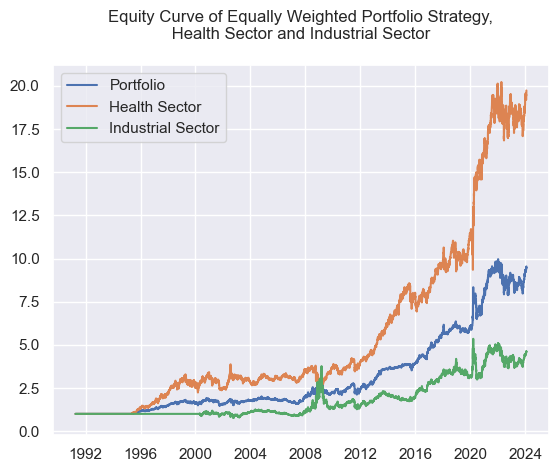

In [382]:
fig, ax = plt.subplots()
df6.reset_index(inplace=True)
ax.plot(df6['Date'], df6['Cumulative Returns'], label='Portfolio')
ax.plot(df4['Date'], df4['Cumulative Returns'], label='Health Sector')
ax.plot(df5['Date'], df5['Cumulative Returns'], label='Industrial Sector')
ax.legend()
plt.title('Equity Curve of Equally Weighted Portfolio Strategy,\n Health Sector and Industrial Sector \n')
plt.show()


The equity curve of the portfolio behaves as the average of the returns of the two sectors.

Annualized returns

In [383]:
#We obtain the annualized return
annualized_return = ((df6['Cumulative Returns'][-1:])**(252/len(df6)) - 1)*100
print('Annualized Return:', annualized_return.iloc[0].round(2), '%')    

Annualized Return: 7.12 %


Sharpe Ratio

Free risk interest rates - 1 year yield FED bond

In [384]:
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime

# Define the start and end dates for the data retrieval
start_date = datetime((df4.Date[0]).year, (df4.Date[0]).month, (df4.Date[0]).day)
end_date = datetime((df4.Date.iloc[-1]).year, (df4.Date.iloc[-1]).month, (df4.Date.iloc[-1]).day)

# Specify the FRED code for the 1-year Treasury bond yield, typically 'GS1'
# This code can vary, so ensure you have the correct one for the 1-year bond
fred_code = 'GS1'

# Fetch the data
try:
    bond_data = pdr.get_data_fred(fred_code, start_date, end_date)
    print(bond_data)
except Exception as e:
    print(f"An error occurred: {e}")

# Optionally, save the data to a CSV file
#bond_data.to_csv('1_year_fed_bond_data.csv')


             GS1
DATE            
1991-05-01  6.13
1991-06-01  6.36
1991-07-01  6.31
1991-08-01  5.78
1991-09-01  5.57
...          ...
2023-10-01  5.42
2023-11-01  5.28
2023-12-01  4.96
2024-01-01  4.79
2024-02-01  4.92

[394 rows x 1 columns]


In [385]:
#Lets transform the GS1 into a DataFrame and merge it with df4
bond_data = pd.DataFrame(bond_data)
bond_data.reset_index(inplace=True)
bond_data.columns = ['Date', 'GS1']
bond_data['Date'] = pd.to_datetime(bond_data['Date'])
bond_data.set_index('Date', inplace=True)


In [386]:
bond_data = (bond_data/100+1)**(1/252)-1

In [387]:
df7 = pd.merge(df4, bond_data, on='Date', how='left')


In [388]:
df7['risk_free'] = df7['GS1'].ffill()

In [389]:
df7.set_index('Date', inplace=True)

In [390]:
df6.set_index('Date', inplace=True)

In [391]:

ereturns2 = df6['portfolio_returns'].resample('M').sum() - np.log((df7['risk_free']+1).resample('M').prod())

In [392]:

sd2 = ereturns2.std(ddof= 1)

# mean of excess returns
m2 = ereturns2.mean()

In [393]:
#Sharpe ratio
sharpe2 = m2/sd2
print('The Sharpe ratio is:', round(sharpe2*100,4), '%')

The Sharpe ratio is: 9.5845 %


### 4. Describe a mechanism that may explain why the principle of contrarian opinion may be observed across many financial markets.

In financial markets, contrarian investing is based on the idea that when the majority of market participants are bullish and buying up assets, eventually, everyone who might be willing to buy has already done so. At this point, there are few buyers left, but many potential sellers who may want to realize their profits. This saturation in buying interest can lead to a situation where any shift in sentiment or market conditions could cause a rapid increase in selling pressure. <br>
<br>
When sellers outnumber buyers, asset prices naturally start to fall. Contrarians aim to anticipate this shift from bullish to bearish sentiment. They might start selling before the peak is reached, or they may hold off on buying until the market sentiment swings overly negative. At the negative extreme, when the market is bearish and asset prices have fallen, contrarians might start buying when most are selling, anticipating a reversal in sentiment that could lead to a price increase.


### 5. Higher feds funds rates lead to declines in stock price indexes. True or false, explain.

 True. It is known that higher federal funds rates typically increase the cost of borrowing money, which can lead to a decrease in business expansion and consumer spending. This, in turn, might negatively affect company profits and dividends, which are key factors in the valuation of stocks as per the Gordon Growth Model. Higher interest rates increase the discount rate used in the valuation of future corporate earnings, making the present value of future cash flows less attractive. In the Gordon Growth Model (Under risk neutrality and no-arbitrage opportunitie), the Price of a Stock is invertional proportional to the free risk interest rate (k) that is usually the fed funds rate. If company profits are expected to decrease due to higher interest rates, investors might sell their stocks in anticipation of falling prices, leading to a decline in stock price indexes. <br>
 As interest rates rise, fixed-income investments become more attractive relative to stocks, leading to a shift in investment from equities to bonds.